# Trading Neural Network Trainer

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from pandas.tseries.offsets import DateOffset

---

## Prepare the data to be used on a neural network model

### Read the csv file into a Pandas DataFrame. clean variables and define target and features

In [2]:
# Read the csv file from the Training_Data folder into a Pandas DataFrame
new_df = pd.read_csv(Path("./Training_Data/XLRE.csv"), index_col="Date", parse_dates=True, infer_datetime_format=True)

# Review the DataFrame
new_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-08,30.010000,30.209999,30.010000,30.209999,24.521376,2000
2015-10-09,30.200001,30.200001,30.059999,30.160000,24.480793,4300
2015-10-12,30.420000,30.420000,30.270000,30.350000,24.635014,2300
2015-10-13,30.160000,30.160000,30.160000,30.160000,24.480793,500
2015-10-14,30.160000,30.160000,30.160000,30.160000,24.480793,0


### Create Function to build Basic Indicators

In [3]:
# Review the data types associated with the columns
data_df = new_df.drop(columns=["Open", "High", "Low", "Adj Close"])

# Make a daily percent change column
data_df["Returns"] = data_df["Close"].pct_change()

# Establishes our basic MAs
data_df["10SMA"] = data_df["Close"].rolling(window=10).mean()
data_df["20SMA"] = data_df["Close"].rolling(window=20).mean()
data_df["50SMA"] = data_df["Close"].rolling(window=50).mean()
data_df["100SMA"] = data_df["Close"].rolling(window=100).mean()

# SMA % Changes
data_df["10SMA_diff"] = (data_df["10SMA"].diff()) / data_df["10SMA"]
data_df["20SMA_diff"] = (data_df["20SMA"].diff()) / data_df["20SMA"]
data_df["50SMA_diff"] = (data_df["50SMA"].diff()) / data_df["50SMA"]
data_df["100SMA_diff"] = (data_df["100SMA"].diff()) / data_df["100SMA"]

# Builds momentum SMAs
data_df["10SMA%"] = data_df["Returns"].rolling(window=10).mean()
data_df["20SMA%"] = data_df["Returns"].rolling(window=20).mean()
data_df["50SMA%"] = data_df["Returns"].rolling(window=50).mean()
data_df["100SMA%"] = data_df["Returns"].rolling(window=100).mean()

# Establishes our basic EMAs
data_df["10EMA"] = data_df["Close"].ewm(span=10, adjust=False).mean()
data_df["20EMA"] = data_df["Close"].ewm(span=20, adjust=False).mean()
data_df["50EMA"] = data_df["Close"].ewm(span=50, adjust=False).mean()
data_df["100EMA"] = data_df["Close"].ewm(span=100, adjust=False).mean()

# EMA % Changes
data_df["10EMA_diff"] = (data_df["10EMA"].diff()) / data_df["10EMA"]
data_df["20EMA_diff"] = (data_df["20EMA"].diff()) / data_df["20EMA"]
data_df["50EMA_diff"] = (data_df["50EMA"].diff()) / data_df["50EMA"]
data_df["100EMA_diff"] = (data_df["100EMA"].diff()) / data_df["100EMA"]


# Builds momentum EMAs
data_df["10EMA%"] = data_df["Returns"].ewm(span=10, adjust=False).mean()
data_df["20EMA%"] = data_df["Returns"].ewm(span=20, adjust=False).mean()
data_df["50EMA%"] = data_df["Returns"].ewm(span=50, adjust=False).mean()
data_df["100EMA%"] = data_df["Returns"].ewm(span=100, adjust=False).mean()

# Builds a standard MACD to opperate on
short_ema = data_df['Close'].ewm(span=12, adjust=False).mean()
long_ema = data_df['Close'].ewm(span=26, adjust=False).mean()
data_df['MACD'] = short_ema - long_ema
data_df['signal'] = data_df['MACD'].ewm(span=9, adjust=False).mean()
data_df['MACD_hist'] = data_df['MACD'] - data_df['signal']

# MACD Histogram diff function
data_df["MACD_hist_diff"] = (data_df["MACD_hist"].diff()) / data_df["MACD_hist"]


# Builds out a standard RSI Indicator

#Creates the up and down columns to use in generating the RSI
data_df['up_tick'] = np.where(data_df['Returns'] > 0, data_df["Returns"], 0.0)
data_df['dn_tick'] = np.where(data_df['Returns'] < 0, abs(data_df["Returns"]), 0.0)

# creates the rolling averages of the up and dn columns for RSI
RS_up = data_df['up_tick'].rolling(window=14).mean()
RS_dn = data_df['dn_tick'].rolling(window=14).mean()

RS = RS_up / RS_dn

# Final Calculation of RSI
data_df['RSI'] = 100 - (100/(1 + RS))


# RSI Diff
data_df["RSI_diff"] = (data_df["RSI"].diff()) / data_df["RSI"]


#Removes columns that are no longer neccesary (we keep uptick to define our trade signal later)

data_df = data_df.drop(columns=["up_tick", "dn_tick"])


# Create Base for WMA, for HullMAs on price, volatility and momentum

# Hull Moving Averages
# Add weights for 10 20 50 
# RHMA = (2 * WMA(n/1)) - WMA(n)
# HMA = WMA(sqrt(n)) of RHMA

# WMA is sum(price * weight (number)) / (n*(n+1))/2

# function that defines the WMA over any period
def WMA(data, length):
       return data.rolling(length).apply(lambda x: ((np.arange(length)+1)*x).sum()/(np.arange(length)+1).sum(), raw=True)


# function that calls the WMA function to calculate the hull moving average    
def HMA(data, length):
       return WMA(WMA(data, length//2).multiply(2).sub(WMA(data, length)), int(np.sqrt(length)))
    
# Add our HMAs to the dataframe
data_df['10HMA'] = HMA(data_df['Close'], 10)
data_df['20HMA'] = HMA(data_df['Close'], 20)
data_df['50HMA'] = HMA(data_df['Close'], 50)
data_df['100HMA'] = HMA(data_df['Close'], 100)



# Add our HMA Diffs
data_df["10HMA_diff"] = (data_df["10HMA"].diff()) / data_df["10HMA"]
data_df["20HMA_diff"] = (data_df["20HMA"].diff()) / data_df["20HMA"]
data_df["50HMA_diff"] = (data_df["50HMA"].diff()) / data_df["50HMA"]
data_df["100HMA_diff"] = (data_df["100HMA"].diff()) / data_df["100HMA"]



# Add Momentum HMAs to the dataframe
data_df['10HMA%'] = HMA(data_df['Returns'], 10)
data_df['20HMA%'] = HMA(data_df['Returns'], 20)
data_df['50HMA%'] = HMA(data_df['Returns'], 50)
data_df['100HMA%'] = HMA(data_df['Returns'], 100)

# and our volatility SMAs
data_df["10VAR"] = data_df["Returns"].rolling(window=10).var()
data_df["20VAR"] = data_df["Returns"].rolling(window=20).var()
data_df["50VAR"] = data_df["Returns"].rolling(window=50).var()
data_df["100VAR"] = data_df["Returns"].rolling(window=100).var()


# Volatility % Changes
data_df["10VAR_diff"] = (data_df["10VAR"].diff()) / data_df["10VAR"]
data_df["20VAR_diff"] = (data_df["20VAR"].diff()) / data_df["20VAR"]
data_df["50VAR_diff"] = (data_df["50VAR"].diff()) / data_df["50VAR"]
data_df["100VAR_diff"] = (data_df["100VAR"].diff()) / data_df["100VAR"]



# Volume MAs
data_df["10SMA_Vol"] = data_df["Volume"].rolling(window=10).mean()
data_df["20SMA_Vol"] = data_df["Volume"].rolling(window=20).mean()
data_df["50SMA_Vol"] = data_df["Volume"].rolling(window=50).mean()
data_df["100SMA_Vol"] = data_df["Volume"].rolling(window=100).mean()

# Volume SMA diffs
data_df["10SMA_Vol_diff"] = (data_df["10SMA_Vol"].diff()) / data_df["10SMA_Vol"]
data_df["20SMA_Vol_diff"] = (data_df["20SMA_Vol"].diff()) / data_df["20SMA_Vol"]
data_df["50SMA_Vol_diff"] = (data_df["50SMA_Vol"].diff()) / data_df["50SMA_Vol"]
data_df["100SMA_Vol_diff"] = (data_df["100SMA_Vol"].diff()) / data_df["100SMA_Vol"]




#data_df.tail(20)
data_df.dtypes

Close              float64
Volume               int64
Returns            float64
10SMA              float64
20SMA              float64
                    ...   
100SMA_Vol         float64
10SMA_Vol_diff     float64
20SMA_Vol_diff     float64
50SMA_Vol_diff     float64
100SMA_Vol_diff    float64
Length: 61, dtype: object

### Build out a Neural Network to train

In [4]:
#First we add our target data

data_df['up_day'] = np.where(data_df['Returns'] > 0, 1.0, 0.0)

# used to be Returns shifting
data_df['Target'] = data_df['up_day'].shift(-1)
data_df = data_df.drop(columns=["up_day"])
#data_df['Target'] = data_df['Returns'].shift(-1)
# and drop our NaN variables to prepare it to train
data_df = data_df.dropna()

data_df.tail()


,Close,Volume,Returns,10SMA,20SMA,50SMA,100SMA,10SMA_diff,20SMA_diff,50SMA_diff,...,100VAR_diff,10SMA_Vol,20SMA_Vol,50SMA_Vol,100SMA_Vol,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff,Target
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-20,47.200001,5596400,0.015272,45.758,45.4590,46.4424,45.9772,0.004677,0.000583,0.000508,...,0.024484,5478860.0,6444395.0,5955942.0,5328008.0,-0.062055,-0.006486,-0.003884,0.003871,1.0
2021-10-21,47.349998,5528800,0.003178,45.982,45.5045,46.4640,46.0107,0.004871,0.001000,0.000465,...,-0.038088,5304760.0,6492260.0,5985030.0,5328173.0,-0.032820,0.007373,0.004860,0.000031,1.0
2021-10-22,47.689999,5378000,0.007181,46.289,45.5935,46.4892,46.0415,0.006632,0.001952,0.000542,...,-0.019602,5296120.0,6500580.0,6017930.0,5335963.0,-0.001631,0.001280,0.005467,0.001460,1.0
2021-10-25,47.830002,4933100,0.002936,46.604,45.7275,46.5110,46.0746,0.006759,0.002930,0.000469,...,-0.000396,5374240.0,6412180.0,6021326.0,5350821.0,0.014536,-0.013786,0.000564,0.002777,1.0
2021-10-26,48.049999,9546200,0.004600,46.881,45.8860,46.5362,46.1095,0.005909,0.003454,0.000542,...,0.002192,5762530.0,6286050.0,6114666.0,5415670.0,0.067382,-0.020065,0.015265,0.011974,0.0


In [5]:
y = data_df["Target"].copy()
y.tail()

X = data_df.drop(columns=["Target",
                          "Close", 
                          "Returns", 
                          "10SMA", 
                          "20SMA", 
                          "50SMA", 
                          "100SMA", 
                          "10EMA", 
                          "20EMA", 
                          "50EMA", 
                          "100EMA", 
                          "MACD", 
                          "signal", 
                          "MACD_hist", 
                          "RSI", 
                          "10HMA", 
                          "20HMA", 
                          "50HMA", 
                          "100HMA", 
                          "Volume", 
                          "10SMA_Vol", 
                          "20SMA_Vol", 
                          "50SMA_Vol", 
                          "100SMA_Vol"]).copy()

X.head()


,10SMA_diff,20SMA_diff,50SMA_diff,100SMA_diff,10SMA%,20SMA%,50SMA%,100SMA%,10EMA_diff,20EMA_diff,...,50VAR,100VAR,10VAR_diff,20VAR_diff,50VAR_diff,100VAR_diff,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,0.001959,0.004357,0.000339,-0.000032,0.001991,0.004450,0.000441,0.000062,0.002720,0.002924,...,0.000235,0.000186,0.067113,-0.333443,-0.042701,0.003142,0.011905,-0.038732,-0.005083,0.002223
2016-03-17,0.005176,0.005473,0.000415,0.000182,0.005199,0.005506,0.000505,0.000270,0.008314,0.005886,...,0.000239,0.000196,0.574650,0.335006,0.016966,0.049218,0.000000,-0.109375,-0.005109,-0.002228
2016-03-18,0.003172,0.004644,0.000264,0.000133,0.003266,0.004754,0.000369,0.000226,0.003688,0.003659,...,0.000243,0.000197,0.216084,0.157569,0.015395,0.006568,0.889109,0.841780,0.628910,0.212097
2016-03-21,0.002712,0.003639,0.000542,0.000066,0.002823,0.003732,0.000634,0.000162,0.002073,0.002802,...,0.000236,0.000197,0.025909,-0.013764,-0.028007,0.001367,0.012386,0.015815,0.008924,0.004449
2016-03-22,0.002676,0.003781,0.000775,0.000046,0.002798,0.003902,0.000861,0.000142,0.001372,0.002358,...,0.000232,0.000197,0.001085,-0.019033,-0.016331,0.000186,0.006477,0.007846,-0.011401,-0.002868


In [6]:
# Set Training periods
training_begin = X.index.min()
training_end = X.index.min() + DateOffset(years=14)

print(training_begin)
print(training_end)

2016-03-16 00:00:00
2030-03-16 00:00:00


In [7]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

display(X_train.head())
display(X_test.head())

,10SMA_diff,20SMA_diff,50SMA_diff,100SMA_diff,10SMA%,20SMA%,50SMA%,100SMA%,10EMA_diff,20EMA_diff,...,50VAR,100VAR,10VAR_diff,20VAR_diff,50VAR_diff,100VAR_diff,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,0.001959,0.004357,0.000339,-0.000032,0.001991,0.004450,0.000441,0.000062,0.002720,0.002924,...,0.000235,0.000186,0.067113,-0.333443,-0.042701,0.003142,0.011905,-0.038732,-0.005083,0.002223
2016-03-17,0.005176,0.005473,0.000415,0.000182,0.005199,0.005506,0.000505,0.000270,0.008314,0.005886,...,0.000239,0.000196,0.574650,0.335006,0.016966,0.049218,0.000000,-0.109375,-0.005109,-0.002228
2016-03-18,0.003172,0.004644,0.000264,0.000133,0.003266,0.004754,0.000369,0.000226,0.003688,0.003659,...,0.000243,0.000197,0.216084,0.157569,0.015395,0.006568,0.889109,0.841780,0.628910,0.212097
2016-03-21,0.002712,0.003639,0.000542,0.000066,0.002823,0.003732,0.000634,0.000162,0.002073,0.002802,...,0.000236,0.000197,0.025909,-0.013764,-0.028007,0.001367,0.012386,0.015815,0.008924,0.004449
2016-03-22,0.002676,0.003781,0.000775,0.000046,0.002798,0.003902,0.000861,0.000142,0.001372,0.002358,...,0.000232,0.000197,0.001085,-0.019033,-0.016331,0.000186,0.006477,0.007846,-0.011401,-0.002868


,10SMA_diff,20SMA_diff,50SMA_diff,100SMA_diff,10SMA%,20SMA%,50SMA%,100SMA%,10EMA_diff,20EMA_diff,...,50VAR,100VAR,10VAR_diff,20VAR_diff,50VAR_diff,100VAR_diff,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff
Date,,,,,,,,,,,,,,,,,,,,,


In [8]:
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 38)) while a minimum of 1 is required by StandardScaler.

In [9]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features


38

In [10]:
# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  (number_input_features + number_output_neurons) // 2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1



19

In [11]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

10

In [12]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer3 =  (hidden_nodes_layer2 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer3

5

In [13]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer4 =  (hidden_nodes_layer3 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer4

3

In [14]:
# Create the Sequential model instance
nn = Sequential()


In [15]:
# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Add a dropout layer
nn.add(Dropout(0.5))

# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add a dropout layer
nn.add(Dropout(0.5))

# Add the third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))

# Add a dropout layer
nn.add(Dropout(0.5))

# Add the fourth hidden layer
nn.add(Dense(units=hidden_nodes_layer4, activation="relu"))

# Add a dropout layer
nn.add(Dropout(0.5))


# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [16]:
# Display the Sequential model summary
nn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                741       
_________________________________________________________________
dropout (Dropout)            (None, 19)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1

In [17]:
# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Fit the model using 50 epochs and the training data
model = nn.fit(X_train_scaled, y_train, epochs=1500, verbose=0)

In [19]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, y_train, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


111/111 - 0s - loss: 0.6797 - accuracy: 0.5898
Loss: 0.6796635389328003, Accuracy: 0.5898382067680359


In [20]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

67/67 - 0s - loss: 0.6951 - accuracy: 0.4525
Loss: 0.6950585842132568, Accuracy: 0.45252716541290283


<AxesSubplot:>

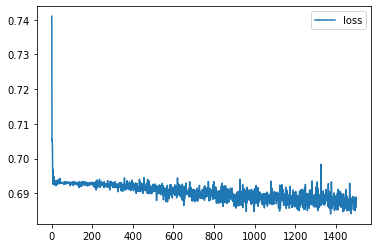

In [21]:
model_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

model_plot.plot(y="loss")

<AxesSubplot:>

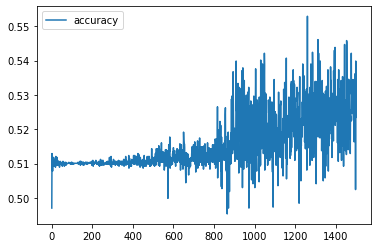

In [22]:
model_plot.plot(y="accuracy")

In [23]:
# Set the file path for the first alternative model
file_path = Path("./ETF_Neural_Nets/saved_neural_nets/XLRE.h5")

# Export your model to a HDF5 file
nn.save(file_path)
